# Learning TensorFlow: Convolutional Neural Networks

## Overview

This tutorial demonstrates 
how to 

1.   Train a custom Convolutional Neural Network(CNN) for performing image classification on Vertex AI using TensorFlow.
2.   Deploy the trained model for online prediction using Vertex AI.

### Dataset

You will train a Convolutional Neural Network(CNN) to classify images of clothing from a dataset called  [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist).

This dataset contains 70,000 items of clothing belonging to 10 different categories of clothing. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

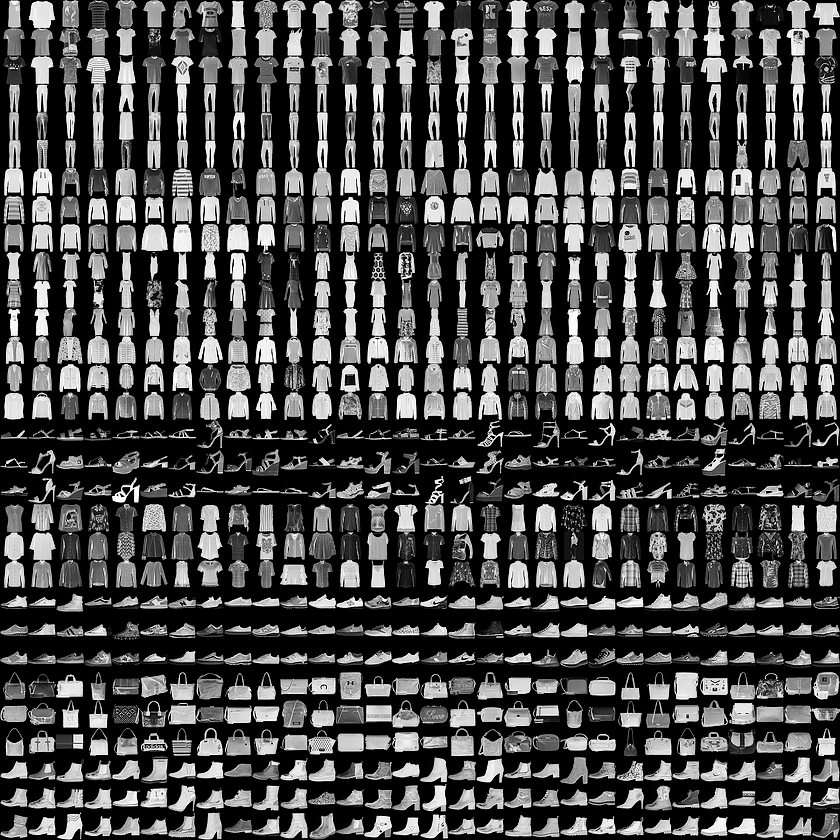

In this notebook, you will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify the images.

The **Fashion MNIST** data is available in [tensorflow datasets(tfds)](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

### Objective

In this notebook, you will create a custom-trained CNN model from a Python script in a Docker container using the Vertex SDK for Python, and then do a prediction on the deployed model by sending data. Alternatively, you can create custom-trained models using `gcloud` command-line tool, or online using the Cloud Console.

The steps performed include:

- Create a Vertex AI custom job and train a CNN model.
- Deploy the `Model` resource to a serving `Endpoint` resource.
- Make a prediction.
- Undeploy the `Model` resource.

## Setting up the environment

In [ ]:
pip install google-cloud-aiplatformpip install protobuf==3.20.1

### Restart the kernel

Once you've installed everything, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`. 

In [ ]:
import os

PROJECT_ID = ""

if not os.getenv("IS_TESTING"):
    # Get your Google Cloud project ID from gcloud
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. Vertex AI runs
the code from this package. In this tutorial, Vertex AI also saves the
trained model that results from your job in the same bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [ ]:
BUCKET_NAME = "gs://[your-bucket-name]"
REGION = "us-central1"  # @param {type:"string"}

In [ ]:
PROJECT_ID

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID

**Only if your bucket doesn't already exist**: Run the following cells to create your Cloud Storage bucket.

In [ ]:
BUCKET_NAME

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

#### Check progress
Go back to lab manual and Click _Check my progress_ under **Create a Cloud Storage bucket** section to verify that the bucket is created.

### Set up variables

Next, set up some variables used throughout the tutorial.

#### Import Vertex SDK for Python

Import the Vertex SDK for Python into your Python environment and initialize it.

In [ ]:
import os
import sys

from google.cloud import aiplatform
from google.cloud.aiplatform import gapic as aip

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

#### Set hardware accelerators

Here to run a container image on a CPU, we set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to `(None, None)` since this notebook is meant to be run in a Qwiklab environment where GPUs cannot be provisioned. 
  
Note: If you happen to be running this notebook from your personal GCP account, set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. For example, to use a GPU container image with 4 Nvidia Tesla K80 GPUs allocated to each VM, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

See the [locations where accelerators are available](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators).

In [ ]:
TRAIN_GPU, TRAIN_NGPU = (None, None)
DEPLOY_GPU, DEPLOY_NGPU = (None, None)

#### Set pre-built containers

There are two ways you can train a custom model using a container image:

- **Use a Google Cloud prebuilt container**. If you use a prebuilt container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.


Here you will use pre-built containers provided by Vertex AI to run training and prediction.

For the latest list, see [Pre-built containers for training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

In [ ]:
TRAIN_VERSION = "tf-cpu.2-8"
DEPLOY_VERSION = "tf2-cpu.2-8"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

#### Set machine types

Next, set the machine types to use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to configure your compute resources for training and prediction.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]

*Note: The following is not supported for training:*

 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs

*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*.

In [ ]:
MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

## Design and Train the Convolutional Neural Network

Now you are ready to design and train your own custom-trained CNN model with Fashion MNIST data.  


### Convolutional Neural Networks(CNN)
In **Introduction to Computer Vision** lab, you saw how to train a Deep Neural Network(DNN) that can classify images of clothing. 
You can improve the accuracy of your DNN achieved by using convolutions. Convolutions narrow down the content of the image to focus on specific distinct details. **Introduction to Convolutions** lab explores convolutions in more detail. Please go through it to gain an in-depth understanding of convolutions.

A Convolutional Neural Network(CNN) is a neural network in which at least one layer is a convolutional layer. A typical CNN consists of some combination of the following layers:

* Convolutional Layers
  * Addition of convolutions enables more focused information to be passed to the dense layers possibly making the model more accurate.
* Pooling Layers
  * Designed to compress the image while maintaining the content of the features that are highlighted by the convolution.
* Dense Layers
  * Performs the task of classification based on the features extracted by the previous convolution layers.

### Training script

In the next cell, you will write the contents of the training script, `task.py`. To summarize, the training script:

- Gets the directory to save the model artifacts from the environment variable `AIP_MODEL_DIR`. This variable is set by the training service.
- Loads the Fashion MNIST dataset from TensorFlow Datasets (tfds).
- Builds a CNN model using `tf.keras` model API. (Please see the code comments for details about the layers in the CNN).
- Compiles the model (`compile()`).
- Trains the model (`fit()`) for the number of epochs specified by the argument `args.epochs`.
- Saves the trained model (`save(MODEL_DIR)`) to the specified model directory.

In [ ]:
%%writefile task.py
# Training Fashion MNIST using CNN

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()

parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')

args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Define batch size
BATCH_SIZE = 32

# Load the dataset
datasets, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True)

# Normalize and batch process the dataset
ds_train = datasets['train'].map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y)).batch(BATCH_SIZE)


# Build the Convolutional Neural Network
# As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size.
# Here, the CNN is configured to process inputs of shape (28, 28, 1), which is the format of Fashion MNIST images
# You start with a stack of Conv2D and MaxPooling2D layers.

# Conv2D layer https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). 
# The next argument specifies the size of the Convolution, in this case, a 3x3 grid.
# `relu` is used as the activation function, which you might recall is the equivalent of returning x when x>0, else returning 0.

# MaxPooling2D layer https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D
# By specifying (2,2) for the MaxPooling, the effect is to quarter the size of the image.

# Dense layers
# The output from the convolution stack is flattened and passed to a set of dense layers for classification.
model = tf.keras.models.Sequential([                               
      tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
model.compile(optimizer = tf.keras.optimizers.Adam(),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])



# Train and save the model

MODEL_DIR = os.getenv("AIP_MODEL_DIR")

model.fit(ds_train, epochs=args.epochs)
model.save(MODEL_DIR)

### Define the command args for the training script

Prepare the command-line arguments to pass to your training script.
- `args`: The command line arguments to pass to the corresponding Python module. In this example, they will be:
  - `"--epochs=" + EPOCHS`: The number of epochs for training.

In [ ]:
JOB_NAME = "custom_job_" + TIMESTAMP
MODEL_DIR = "{}/{}".format(BUCKET_NAME, JOB_NAME)

EPOCHS = 5

CMDARGS = [
    "--epochs=" + str(EPOCHS),
]

### Train the model

Define your custom training job on Vertex AI.

Use the `CustomTrainingJob` class to define the job, which takes the following parameters:

- `display_name`: The user-defined name of this training pipeline.
- `script_path`: The local path to the training script.
- `container_uri`: The URI of the training container image.
- `requirements`: The list of Python package dependencies of the script.
- `model_serving_container_image_uri`: The URI of a container that can serve predictions for your model — either a prebuilt container or a custom container.

Use the `run` function to start training, which takes the following parameters:

- `args`: The command line arguments to be passed to the Python script.
- `replica_count`: The number of worker replicas.
- `model_display_name`: The display name of the `Model` if the script produces a managed `Model`.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.

The `run` function creates a training pipeline that trains and creates a `Model` object. After the training pipeline completes, the `run` function returns the `Model` object.

You can read more about the `CustomTrainingJob.run` API [here](https://googleapis.dev/python/aiplatform/latest/aiplatform.html?highlight=customtraining#google.cloud.aiplatform.CustomTrainingJob.run)

In [ ]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    script_path="task.py",
    container_uri=TRAIN_IMAGE,
    requirements=["tensorflow_datasets==4.6.0"],
    model_serving_container_image_uri=DEPLOY_IMAGE,
)

MODEL_DISPLAY_NAME = "fashionmnist-" + TIMESTAMP

# Start the training
if TRAIN_GPU:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_type=TRAIN_GPU.name,
        accelerator_count=TRAIN_NGPU,
    )
else:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_count=0,
    )

The Training pipeline will take an average of **10 to 12 minutes** to finish.

To view the training pipeline status, you have to navigate to **Vertex AI** ➞ **Training**  

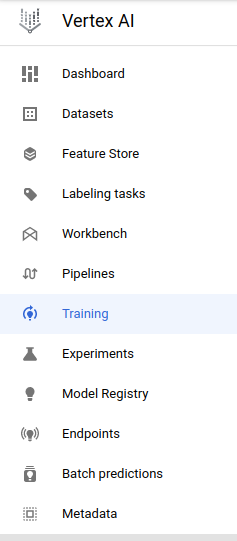

You can see the status of the current training pipeline as seen below

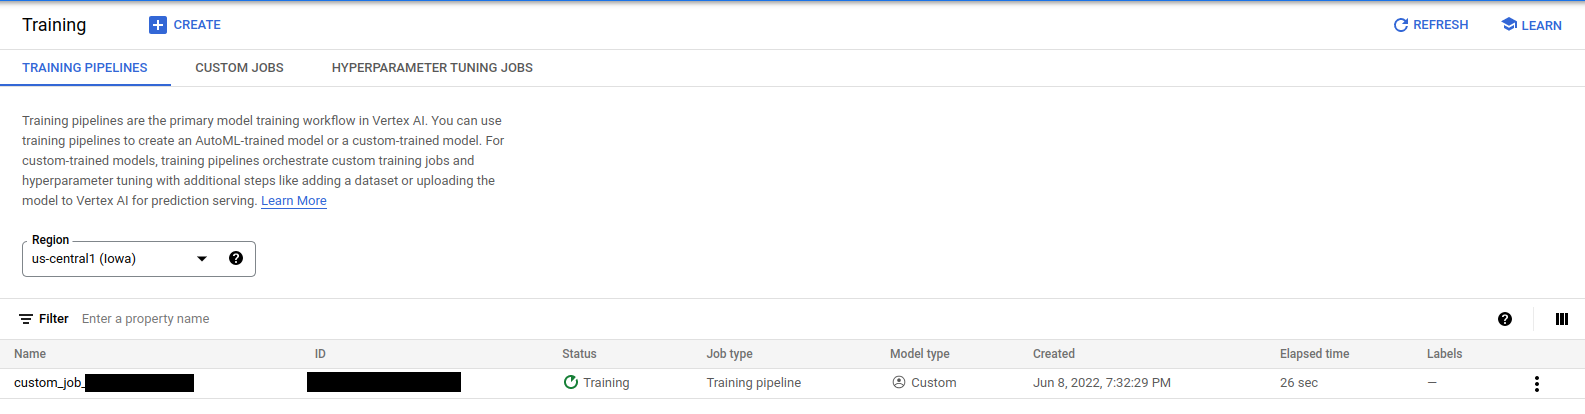

Once the model has been successfully trained, you can see a custom trained model if you head to **Vertex AI** ➞ **Model Registry**

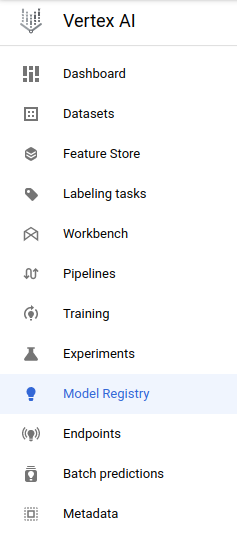

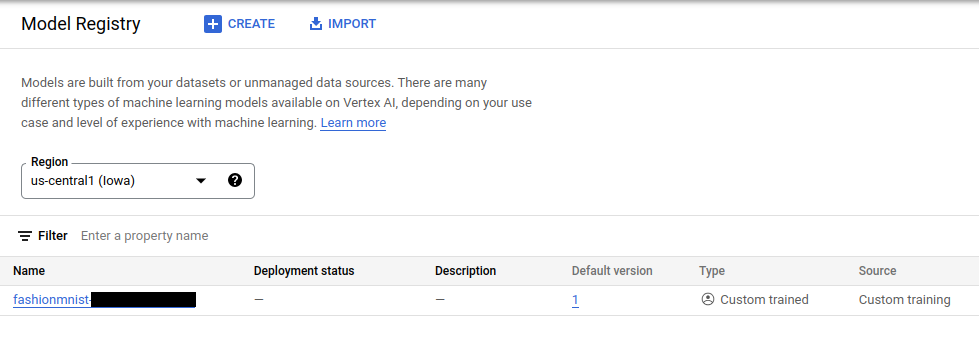

### Check progress
Go back to lab manual and Click _Check my progress_ under **Train the Model on Vertex AI** section to verify that the pipeline ran successfully.

## Deploy the model

Before you use your model to make predictions, you need to deploy it to an `Endpoint`. You can do this by calling the `deploy` function on the `Model` resource. This will do two things:

1. Create an `Endpoint` resource for deploying the `Model` resource to.
2. Deploy the `Model` resource to the `Endpoint` resource.


The function takes the following parameters:

- `deployed_model_display_name`: A human readable name for the deployed model.
- `traffic_split`: Percent of traffic at the endpoint that goes to this model, which is specified as a dictionary of one or more key/value pairs.
   - If only one model, then specify as **{ "0": 100 }**, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
   - If there are existing models on the endpoint, for which the traffic will be split, then use `model_id` to specify as **{ "0": percent, model_id: percent, ... }**, where `model_id` is the model id of an existing model to the deployed endpoint. The percents must add up to 100.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.
- `starting_replica_count`: The number of compute instances to initially provision.
- `max_replica_count`: The maximum number of compute instances to scale to. In this tutorial, only one instance is provisioned.

### Traffic split

The `traffic_split` parameter is specified as a Python dictionary. You can deploy more than one instance of your model to an endpoint, and then set the percentage of traffic that goes to each instance.

You can use a traffic split to introduce a new model gradually into production. For example, if you had one existing model in production with 100% of the traffic, you could deploy a new model to the same endpoint, direct 10% of traffic to it, and reduce the original model's traffic to 90%. This allows you to monitor the new model's performance while minimizing the distruption to the majority of users.

### Compute instance scaling

You can specify a single instance (or node) to serve your online prediction requests. This tutorial uses a single node, so the variables `MIN_NODES` and `MAX_NODES` are both set to `1`.

If you want to use multiple nodes to serve your online prediction requests, set `MAX_NODES` to the maximum number of nodes you want to use. Vertex AI autoscales the number of nodes used to serve your predictions, up to the maximum number you set. Refer to the [pricing page](https://cloud.google.com/vertex-ai/pricing#prediction-prices) to understand the costs of autoscaling with multiple nodes.

### Endpoint

The method will block until the model is deployed and eventually return an `Endpoint` object. If this is the first time a model is deployed to the endpoint, it may take a few additional minutes to complete provisioning of resources.

In [ ]:
DEPLOYED_NAME = "fashionmnist_deployed-" + TIMESTAMP

TRAFFIC_SPLIT = {"0": 100}

MIN_NODES = 1
MAX_NODES = 1

if DEPLOY_GPU:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=DEPLOY_GPU.name,
        accelerator_count=DEPLOY_NGPU,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
    )
else:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=None,
        accelerator_count=0,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
    )

The Deployment process will take an average of **15 to 17 minutes** to finish.

In order to view your deployed endpoint, you can head over to **Vertex AI** ➞ **Endpoints**

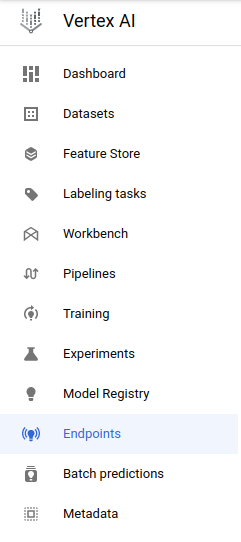



You can check if your endpoint is in the list of the currently deployed/deploying endpoints.

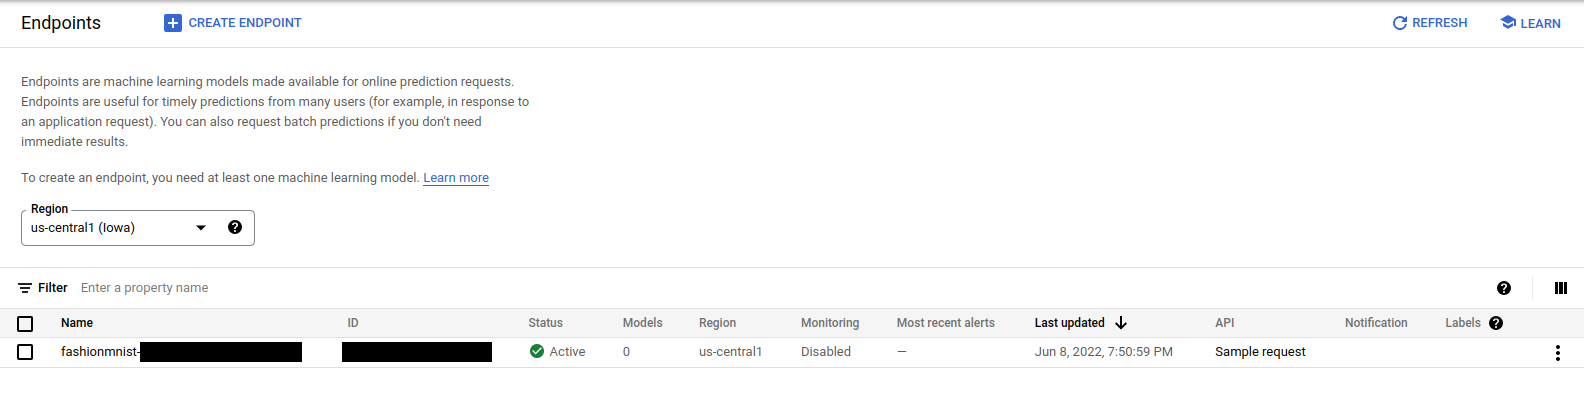

To view the details of the endpoint that is currently being deployed, you can simply click on the endpoint name.

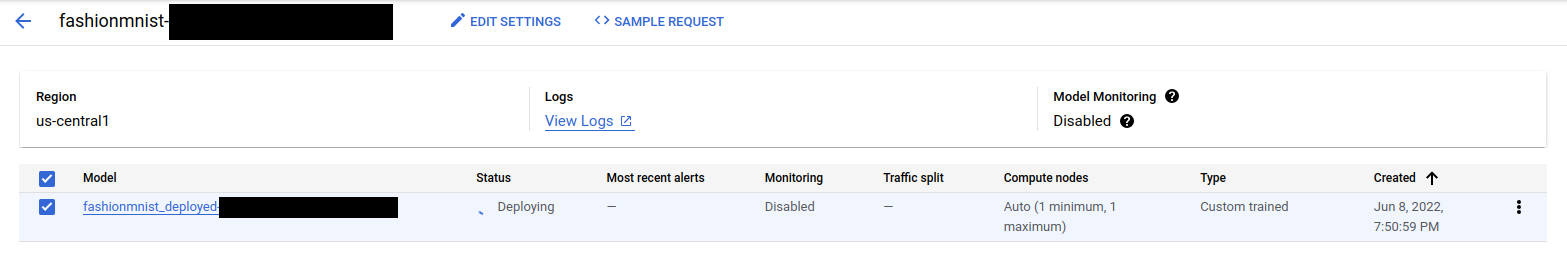

Once deployment is successful, the status will change to **Ready** in the above screenshot.

### Check progress
Go back to lab manual and Click _Check my progress_ under **Deploy the Model** section to verify that the deployment was a success.

## Make an online prediction request

You will now see how an online prediction request can be sent to your deployed model.

First, you will load the test split of the Fashion MNIST dataset using `tfds`.

Set the batch size to -1 to load the entire dataset.

In [ ]:
import tensorflow_datasets as tfds
import numpy as np

tfds.disable_progress_bar()

In [ ]:
datasets, info = tfds.load('fashion_mnist', batch_size=-1, with_info=True, as_supervised=True)

test_dataset = datasets['test']

Now you will convert the dataset to NumPy arrays (images, labels).
The images used for training the model were normalized. Hence the trained model expects normalized images for prediction. You will normalize the test images by dividing each pixel by 255.

In [ ]:
x_test, y_test = tfds.as_numpy(test_dataset)

# Normalize (rescale) the pixel data by dividing each pixel by 255. 
x_test = x_test.astype('float32') / 255.

Ensure the shapes are correct.

In [ ]:
x_test.shape, y_test.shape

In [ ]:
#@title Pick the number of test images
NUM_TEST_IMAGES = 20 #@param {type:"slider", min:1, max:20, step:1}
x_test, y_test = x_test[:NUM_TEST_IMAGES], y_test[:NUM_TEST_IMAGES]

### Send the prediction request

Now that you have prepared the test images, you can use them to send a prediction request. Use the `Endpoint` object's `predict` function, which takes the following parameters:

- `instances`: A list of image instances. According to your custom model, each image instance should be a 3-dimensional matrix of floats. This was prepared in the previous step.

The `predict` function returns a list, where each element in the list corresponds to the corresponding image in the request. The ouput for each prediction will contain:

- Confidence level for the prediction (`predictions`), between 0 and 1, for each of the ten classes.

Now you can run a quick evaluation on the prediction results:
1. `np.argmax`: Convert each list of confidence levels to a label
2. Compare the predicted labels to the actual labels
3. Calculate `accuracy` as `no: of correct predictions/total no: of predictions`

In [ ]:
predictions = endpoint.predict(instances=x_test.tolist())
y_predicted = np.argmax(predictions.predictions, axis=1)

correct = sum(y_predicted == np.array(y_test.tolist()))
total = len(y_predicted)
print(
    f"Correct predictions = {correct}, Total predictions = {total}, Accuracy = {correct/total}"
)